<a href="https://colab.research.google.com/github/cpn-paladino/codestage-sony-deepLearning/blob/main/Reconhecer_Libras_pela_camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=2, size=(400,300)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

In [56]:
cap = take_photo() #clicar na imagem da webcam para tirar uma foto

In [57]:
import time
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab.patches import cv2_imshow


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#CRIAR AS BIBLIOTECAS LOCAIS DO DRIVE
pose_path = "/content/drive/My Drive/pose.zip"
zip_object = zipfile.ZipFile(file=pose_path, mode="r")
zip_object.extractall("./")
imagens_path = "/content/drive/My Drive/imagens.zip"
zip_object = zipfile.ZipFile(file=imagens_path, mode="r")
zip_object.extractall("./")
modulos_path = "/content/drive/My Drive/modulos.zip"
zip_object = zipfile.ZipFile(file=modulos_path, mode="r")
zip_object.extractall("./")
zip_object.close()
sys.path.append("/content/modulos/")
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/modulos/',
 '/content/modulos/',
 '/content/modulos/']

In [60]:
#sys.path.append('/content/drive/My Drive/Colab Notebooks/Modulos/')
#print(sys.path)


In [61]:
import extrator_POSICAO as posicao, extrator_ALTURA as altura, extrator_PROXIMIDADE as proximidade, alfabeto

In [62]:
arquivoProto = "/content/pose/hand/pose_deploy.prototxt"
modeloCaffe = "/content/pose/hand/pose_iter_102000.caffemodel"
nPontos = 22
PARES_POSE = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], [10, 11], [11, 12],
              [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

In [63]:
letras = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']

In [64]:
net = cv2.dnn.readNetFromCaffe(arquivoProto, modeloCaffe)

In [65]:
limite=0.1

In [66]:
frame = cap

In [67]:
frameCopia = np.copy(frame)

In [68]:
frameLargura = frame.shape[1]
frameAltura = frame.shape[0]
janela = frameLargura / frameAltura

In [69]:
corPonto_A, corPonto_B, corLinha, corTxtPonto, corTxtAprov, corTxtWait = (14, 201, 255), (255, 0, 128), (192, 192, 192), \
                                                                         (10, 216, 245), (255, 0, 128), (192, 192, 192)
tamFont, tamLine, tamCircle, espessura = 2, 1, 4, 2
fonte = cv2.FONT_HERSHEY_SIMPLEX

In [70]:
t = time.time()
entradaAltura = 368
entradaLargura = int(((janela * entradaAltura) * 8) // 8)

In [71]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (entradaLargura, entradaAltura), (0, 0, 0), swapRB=False, crop=False)

In [72]:
net.setInput(inpBlob)
saida = net.forward()
print("Tempo da Rede: {:.2f}sec".format(time.time() - t))

Tempo da Rede: 8.17sec


In [73]:
pontos = []

In [74]:
    tamanho = cv2.resize(frame, (frameLargura, frameAltura))
    mapaSuave = cv2.GaussianBlur(tamanho, (3, 3), 0, 0)
    fundo = np.uint8(mapaSuave > limite)

In [75]:
for i in range(nPontos):
    mapaConfianca = saida[0, i, :, :]
    mapaConfianca = cv2.resize(mapaConfianca, (frameLargura, frameAltura))

    minVal, confianca, minLoc, ponto = cv2.minMaxLoc(mapaConfianca)

    if confianca > limite:
        cv2.circle(frameCopia, (int(ponto[0]), int(ponto[1])), 5, corPonto_A, thickness=espessura, lineType=cv2.FILLED)
        cv2.putText(frameCopia, ' ' + (str(int(ponto[0]))) + ',' + str(int(ponto[1])), (int(ponto[0]), int(ponto[1])),
                    fonte, 0.3, corTxtAprov, 0, lineType=cv2.LINE_AA)
        
        cv2.circle(frame, (int(ponto[0]), int(ponto[1])), tamCircle, corPonto_A, thickness=espessura,
                   lineType=cv2.FILLED)
        cv2.putText(frame, ' ' + "{}".format(i), (int(ponto[0]), int(ponto[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
                    corTxtAprov,
                    0, lineType=cv2.LINE_AA)
        
        cv2.circle(fundo, (int(ponto[0]), int(ponto[1])), tamCircle, corPonto_A, thickness=espessura,
                   lineType=cv2.FILLED)
        cv2.putText(fundo, ' ' + "{}".format(i), (int(ponto[0]), int(ponto[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
                    corTxtAprov,
                    0, lineType=cv2.LINE_AA)

        pontos.append((int(ponto[0]), int(ponto[1])))

    else:
        pontos.append((0, 0))

In [76]:
for par in PARES_POSE:
    partA = par[0]
    partB = par[1]

    if pontos[partA] != (0, 0) and pontos[partB] != (0, 0):
        cv2.line(frameCopia, pontos[partA], pontos[partB], corLinha, tamLine, lineType=cv2.LINE_AA)
        cv2.line(frame, pontos[partA], pontos[partB], corLinha, tamLine, lineType=cv2.LINE_AA)        
        cv2.line(fundo, pontos[partA], pontos[partB], corLinha, tamLine, lineType=cv2.LINE_AA)

In [77]:
posicao.posicoes = []

In [78]:
# Dedo polegar
posicao.verificar_posicao_DEDOS(pontos[1:5], 'polegar', altura.verificar_altura_MAO(pontos))

# Dedo indicador
posicao.verificar_posicao_DEDOS(pontos[5:9], 'indicador', altura.verificar_altura_MAO(pontos))

# Dedo médio
posicao.verificar_posicao_DEDOS(pontos[9:13], 'medio', altura.verificar_altura_MAO(pontos))

# Dedo anelar
posicao.verificar_posicao_DEDOS(pontos[13:17], 'anelar', altura.verificar_altura_MAO(pontos))

# Dedo mínimo-
posicao.verificar_posicao_DEDOS(pontos[17:21], 'minimo', altura.verificar_altura_MAO(pontos))

In [79]:
print(proximidade.verificar_proximidade_DEDOS(pontos))

['polegar esticado horizontal: afastado do indicador', 'indicador dobrado: proximo ao medio', 'medio dobrado: proximo ao anelar', 'anelar dobrado: proximo ao minimo', 'minimo dobrado: proximo ao anelar']


In [80]:
letraLibra = "desconhecido"
for i, a in enumerate(alfabeto.letras):
    if proximidade.verificar_proximidade_DEDOS(pontos) == alfabeto.letras[i]:
        cv2.putText(frame, '' + letras[i], (50, 50), fonte, 1.5, corTxtAprov, tamFont,
                    lineType=cv2.LINE_AA)
        letraLibra = letras[i]
print(letraLibra)        

O


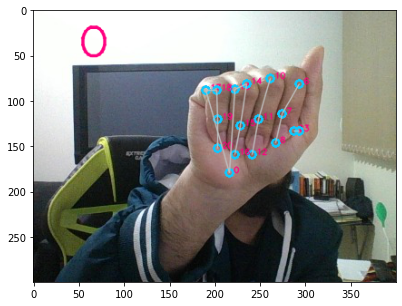

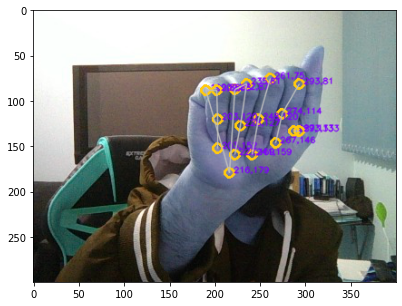

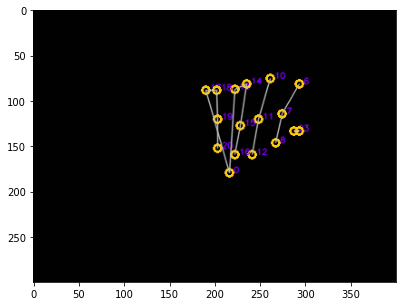

Tempo total de execução : 8.914


-1

In [81]:
plt.figure(figsize=[7,5])
plt.imshow(frame)

plt.figure(figsize=[7,5])
plt.imshow(cv2.cvtColor(frameCopia, cv2.COLOR_BGR2RGB))

plt.figure(figsize=[7,5])
plt.imshow(cv2.cvtColor(fundo, cv2.COLOR_BGR2RGB))


plt.show()

print("Tempo total de execução : {:.3f}".format(time.time() - t))

cv2.waitKey(0)